# Hiking Trails Data Analysis
This notebook will explore the following:
- Average number of reviews with and without comments per trail
- Distribution of trail difficulty
- Distribution of trail length
- Distribution of trail ratings
- Frequency of terms used in trail reviews 

In [4]:
import json
import pprint

import numpy as np
import matplotlib.pyplot as plt

import re
from collections import Counter
import math

In [5]:
with open('ithacatrails.json') as f:
    data = json.load(f)
    
# Example data
pprint.pprint(data['Ellis Hollow Yellow trail'])

{'AllTrails ID': 10299831,
 'Description': 'Need a break from the hassles of everyday life?  A walk '
                'through the fern-carpeted forests of the Ellis Hollow Nature '
                'Preserve could be just the thing.  In winter, take your '
                'cross-country skis to enjoy one of the peaceful, snow-covered '
                'loop trails.  Just a short drive from downtown Ithaca, this '
                '150-acre preserve on the northern hillside of the Ellis '
                'Hollow valley has 2 miles of hiking trails. The parking area '
                "and initial stretch of trail gives no hint of what's to "
                'come.  After 500 feet you will find an informational kiosk '
                'which marks the junction where the trail splits into a series '
                'of nested loops.  Starting to the left will take you along a '
                'stream and through a forest where shady eastern hemlock often '
                'dominates.  The 

# Distribution of Static Attributes

In [6]:
print(f"Number of trails: {len(data.keys())}")

Number of trails: 102


In [7]:
num_total_reviews = np.sum(np.array([len(d['Reviews']) for d in data.values()]))
print(f"Total number of reviews: {num_total_reviews}")

Total number of reviews: 15172


In [8]:
total_reviews_with_comments = []
for d in data.values():
    reviews = d['Reviews']
    total_reviews_with_comments += [r for r in reviews if r['comment'] != ""]

num_reviews_with_comments = len(total_reviews_with_comments)
print(f"Total number of reviews with comments: {num_reviews_with_comments}")
print(f"Total number of reviews without comments: {num_total_reviews - num_reviews_with_comments}")

Total number of reviews with comments: 4065
Total number of reviews without comments: 11107


## Distribution of Trail Ratings

(array([ 102.,  510., 2040., 5916., 9894.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

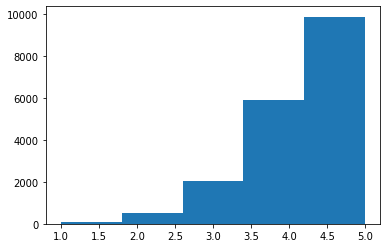

In [9]:
trail_ratings = [review['rating'] for review in d['Reviews'] for d in data.values() if review['rating'] is not None]

plt.hist(trail_ratings, 5)

## Distribution of Trail Lengths

(array([49., 33., 13.,  6.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.01 , 0.509, 1.008, 1.507, 2.006, 2.505, 3.004, 3.503, 4.002,
        4.501, 5.   ]),
 <a list of 10 Patch objects>)

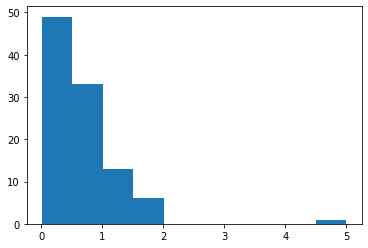

In [10]:
trail_lengths = [d['Distance'] for d in data.values()]

plt.hist(trail_lengths)

## Distribution of Trail Difficulties
This is based solely on the Ithaca Trails description, and not on user reviews yet.

(array([73.,  0., 22.,  0.,  0.,  2.,  0.,  4.,  0.,  1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

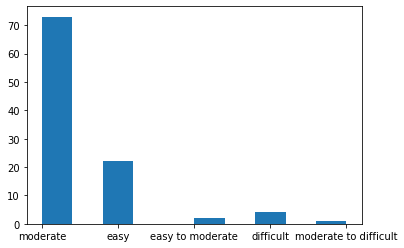

In [11]:
trail_difficulties = [d['Difficulty'] for d in data.values()]

plt.hist(trail_difficulties)

## Frequency of terms used in trail reviews
Solely based on Alltrails review comments

In [25]:
# get all tokens
def get_tokens():
    tokens = set()
    for trail in data:
        for review in data[trail]['Reviews']:
            tokens.update(set(re.findall('[a-z]+', review['comment'])))
    tokens = list(tokens)
    return tokens
tokens = get_tokens()

def get_tokens_to_idx(tokens):
    tokens_to_index = {}
    for i in range(len(tokens)):
        tokens_to_index[tokens[i]] = i
    return tokens_to_index

tokens_to_index = get_tokens_to_idx(tokens)

def build_inverted_index():
    inv_idx = {}
    for i, trail in enumerate(data):
        words = []
        for review in data[trail]['Reviews']:
            words.extend(re.findall('[a-z]+', review['comment']))
        tfs = Counter(words)
        for word in words:
            val = inv_idx.get(word, [])
            val.append((i, tfs[word]))
            inv_idx[word] = val
    return inv_idx

inv_idx = build_inverted_index()

def get_idfs(min_df=15, max_df_ratio=0.9):      
    idfs = {}
    for term in inv_idx:
        n_docs_t = len(inv_idx[term])
        if n_docs_t >= min_df and (n_docs_t/len(data)) <= max_df_ratio:
            idfs[term] = math.log((len(data)/(1 + n_docs_t)), 2)
    return idfs

idfs = get_idfs()

def get_tf_idf_scores():
    tf_idf = {}
    for tok in inv_idx:
        if tok in idfs:
            for post in inv_idx[tok]:
                val = tf_idf.get(tok, 0)
                val += post[1] * idfs[tok]
                tf_idf[tok] = val
    tf_idfs = [(k,v) for k, v in tf_idf.items()]
    tf_idfs.sort(reverse=True, key = lambda x: x[1])
    return tf_idfs
#     return tf_idf

tf_idfs = get_tf_idf_scores()

def build_tf_mat():
    tf_mat = np.zeros((len(data), len(tokens)))
    for i, trail in enumerate(data):
        words = []
        for review in data[trail]['Reviews']:
            words.extend(re.findall('[a-z]+', review['comment']))
        for word in words:
            tf_mat[i,tokens_to_index[word]] += 1
    return tf_mat 
print(f"The top 10 most frequent words used in reviews: \n{tf_idfs[:10]}\n\n")
print(f"The top 10 least frequent words used in reviews: \n{tf_idfs[-10:]}")

The top 10 most frequent words used in reviews: 
[('field', 735.8701126210949), ('red', 558.7805444430882), ('upper', 539.4039255857514), ('ear', 530.9624377415872), ('how', 523.8700445514148), ('south', 476.4499429036956), ('workout', 470.4400156879261), ('orange', 459.8564128579055), ('outh', 451.97331508113786), ('dip', 442.7244206299176)]


The top 10 least frequent words used in reviews: 
[('network', 41.35940001153848), ('thoughts', 41.35940001153848), ('mind', 40.08638012957245), ('heads', 40.08638012957245), ('h', 40.08638012957245), ('icy', 37.6624366363641), ('route', 34.572447372287826), ('trees', 34.32119377152188), ('find', 32.89880828710061), ('lovely', 32.65085722684627)]
